In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import warnings
warnings.filterwarnings('ignore')

import os
cwd = os.getcwd().split('\\')
local_repo_path = '\\'.join(cwd[:-1])
raw_data_path = local_repo_path + '\\data\\raw'
processed_data_path = local_repo_path + '\\data\\processed'
feature_path = local_repo_path + '\\data\\features'
model_path = local_repo_path + '\\model_submissions'

In [2]:
output_feature_fname = 'Lookback10'
sj_feature_train = pd.read_csv(feature_path + r'\\sj_train_' + output_feature_fname + '.csv', index_col = 0)
sj_feature_test = pd.read_csv(feature_path + r'\\sj_test_' + output_feature_fname + '.csv', index_col = 0)
iq_feature_train = pd.read_csv(feature_path + r'\\iq_train_' + output_feature_fname + '.csv', index_col = 0)
iq_feature_test = pd.read_csv(feature_path + r'\\iq_test_' + output_feature_fname + '.csv', index_col = 0)

In [3]:
sj_feature_test.head()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),var5(t-9),...,var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),city,year,weekofyear
0,-0.880088,-0.902578,-0.992343,-0.500000,-0.261864,-1.099356,-1.148990,-1.059724,-0.772727,-0.300411,...,-0.500000,-0.520492,-0.445389,-0.455470,-0.073507,0.227273,-0.535167,sj,2008,18
1,-1.099356,-1.148990,-1.059724,-0.772727,-0.300411,-0.904755,-0.934355,-0.900459,-0.772727,-0.338042,...,0.227273,-0.535167,-0.350555,-0.359024,-0.294028,-0.500000,-0.542448,sj,2008,19
2,-0.904755,-0.934355,-0.900459,-0.772727,-0.338042,-1.193641,-1.268293,-0.808576,-0.272727,-0.374707,...,-0.500000,-0.542448,-0.399342,-0.410314,-0.490046,-0.272727,-0.541333,sj,2008,20
3,-1.193641,-1.268293,-0.808576,-0.272727,-0.374707,-1.187611,-1.264948,-0.863706,-1.000000,-0.409986,...,-0.272727,-0.541333,-0.060573,-0.054077,0.306279,0.000000,-0.530953,sj,2008,21
4,-1.187611,-1.264948,-0.863706,-1.000000,-0.409986,-1.223242,-1.307875,-0.931087,-0.772727,-0.443178,...,0.000000,-0.530953,-0.405372,-0.407526,0.361409,0.727273,-0.510605,sj,2008,22


In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from math import sqrt
from matplotlib import pyplot
from numpy import array
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [5]:
def fit_and_predict_LSTM(train_wide, test_wide, epochs = 200, n_hidden = 25, activation = 'linear', verbose = 0):
    values = train_wide.values
    n_train = values.shape[0] - 200
    train = values[:n_train, :]
    val = values[n_train:, :]
    
    train_x, train_y = train[:, :-1], train[:, -1]
    val_x, val_y = val[:, :-1], val[:, -1]
    
    train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
    val_x = val_x.reshape((val_x.shape[0], 1, val_x.shape[1]))
    test_x = test_wide.drop(['city', 'year', 'weekofyear'], axis = 1).values
    test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
    
    model = Sequential()
    model.add(LSTM(n_hidden, input_shape=(train_x.shape[1], train_x.shape[2])))
    model.add(Dropout(0.4))
    model.add(Dense(n_hidden))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    history = model.fit(train_x, train_y, epochs = epochs, batch_size = 72, validation_data = (val_x, val_y), verbose = verbose, shuffle = False)
    
    plt.figure(figsize = (7,5))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
    
    test_preds = model.predict(test_x)
    
    train_x_full = values[:, :-1]
    train_preds = model.predict(train_x_full.reshape((train_x_full.shape[0], 1, train_x_full.shape[1])))
    fig, ax = plt.subplots(figsize = (20,10))
    train_error = np.round(mean_absolute_error(train_preds, train_wide['total_cases']), 1)
    pd.DataFrame(train_preds).plot(ax = ax)
    pd.DataFrame(train_wide['total_cases']).reset_index(drop = True).plot(ax = ax)
    pd.DataFrame(test_preds).set_index(np.arange(len(train_wide), len(train_wide) + len(test_preds))).plot(ax = ax)
    
    ax.legend(labels = ['Fitted', 'True', 'Predicted'])
    ax.set_title('Mean train error: ' + str(train_error))
    return(model, train_preds, test_preds)

In [6]:
sj_feature_train_log_cases = sj_feature_train.copy()
sj_feature_train_log_cases['total_cases'] = np.log(1 + sj_feature_train_log_cases['total_cases'])


Train on 726 samples, validate on 200 samples
Epoch 1/400
 - 1s - loss: 37.2849 - val_loss: 23.6729
Epoch 2/400
 - 0s - loss: 36.9313 - val_loss: 23.2973
Epoch 3/400
 - 0s - loss: 36.4231 - val_loss: 22.7720
Epoch 4/400
 - 0s - loss: 35.7260 - val_loss: 22.1886
Epoch 5/400
 - 0s - loss: 34.7978 - val_loss: 21.4848
Epoch 6/400
 - 0s - loss: 33.7731 - val_loss: 20.6204
Epoch 7/400
 - 0s - loss: 32.5759 - val_loss: 19.7494
Epoch 8/400
 - 0s - loss: 31.3475 - val_loss: 18.7395
Epoch 9/400
 - 0s - loss: 30.2118 - val_loss: 17.8344
Epoch 10/400
 - 0s - loss: 28.8939 - val_loss: 17.2727
Epoch 11/400
 - 0s - loss: 27.5066 - val_loss: 17.1094
Epoch 12/400
 - 0s - loss: 26.3203 - val_loss: 17.0794
Epoch 13/400
 - 0s - loss: 25.3992 - val_loss: 17.3197
Epoch 14/400
 - 0s - loss: 24.8644 - val_loss: 17.6327
Epoch 15/400
 - 0s - loss: 24.2206 - val_loss: 17.8812
Epoch 16/400
 - 0s - loss: 24.2944 - val_loss: 17.9061
Epoch 17/400
 - 0s - loss: 23.9209 - val_loss: 17.8566
Epoch 18/400
 - 0s - loss: 

Epoch 145/400
 - 0s - loss: 22.5773 - val_loss: 18.9784
Epoch 146/400
 - 0s - loss: 22.0724 - val_loss: 18.8352
Epoch 147/400
 - 0s - loss: 22.2111 - val_loss: 18.6553
Epoch 148/400
 - 0s - loss: 22.4849 - val_loss: 18.7446
Epoch 149/400
 - 0s - loss: 22.0811 - val_loss: 18.7570
Epoch 150/400
 - 0s - loss: 22.1919 - val_loss: 18.8047
Epoch 151/400
 - 0s - loss: 21.8250 - val_loss: 18.8546
Epoch 152/400
 - 0s - loss: 21.8582 - val_loss: 18.7885
Epoch 153/400
 - 0s - loss: 22.0969 - val_loss: 18.7360
Epoch 154/400
 - 0s - loss: 22.4329 - val_loss: 18.8590
Epoch 155/400
 - 0s - loss: 22.6201 - val_loss: 19.0562
Epoch 156/400
 - 0s - loss: 22.1331 - val_loss: 19.0670
Epoch 157/400
 - 0s - loss: 22.4108 - val_loss: 19.0370
Epoch 158/400
 - 0s - loss: 22.0366 - val_loss: 19.0229
Epoch 159/400
 - 0s - loss: 21.9087 - val_loss: 18.9775
Epoch 160/400
 - 0s - loss: 22.0620 - val_loss: 18.9034
Epoch 161/400
 - 0s - loss: 21.8635 - val_loss: 18.7710
Epoch 162/400
 - 0s - loss: 21.7543 - val_loss: 

Epoch 292/400
 - 0s - loss: 20.8476 - val_loss: 19.4116
Epoch 293/400
 - 0s - loss: 20.9760 - val_loss: 19.4156
Epoch 294/400
 - 0s - loss: 21.2579 - val_loss: 19.3740
Epoch 295/400
 - 0s - loss: 21.3260 - val_loss: 19.0243
Epoch 296/400
 - 0s - loss: 21.5141 - val_loss: 19.2402
Epoch 297/400
 - 0s - loss: 20.8819 - val_loss: 19.4412
Epoch 298/400
 - 0s - loss: 20.6372 - val_loss: 19.5188
Epoch 299/400
 - 0s - loss: 20.9581 - val_loss: 19.5773
Epoch 300/400
 - 0s - loss: 21.3217 - val_loss: 19.3743
Epoch 301/400
 - 0s - loss: 20.6652 - val_loss: 19.2811
Epoch 302/400
 - 0s - loss: 21.3951 - val_loss: 19.3391
Epoch 303/400
 - 0s - loss: 21.0164 - val_loss: 19.3490
Epoch 304/400
 - 0s - loss: 20.9941 - val_loss: 19.2119
Epoch 305/400
 - 0s - loss: 21.6719 - val_loss: 19.1099
Epoch 306/400
 - 0s - loss: 21.2691 - val_loss: 19.0771
Epoch 307/400
 - 0s - loss: 21.4430 - val_loss: 19.6194
Epoch 308/400
 - 0s - loss: 20.7670 - val_loss: 19.9293
Epoch 309/400
 - 0s - loss: 21.4481 - val_loss: 

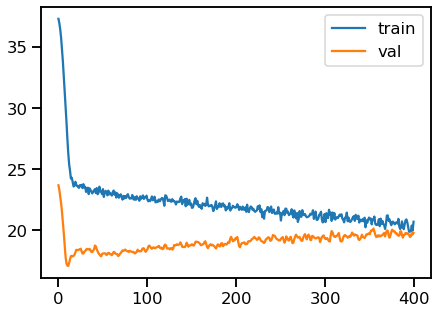

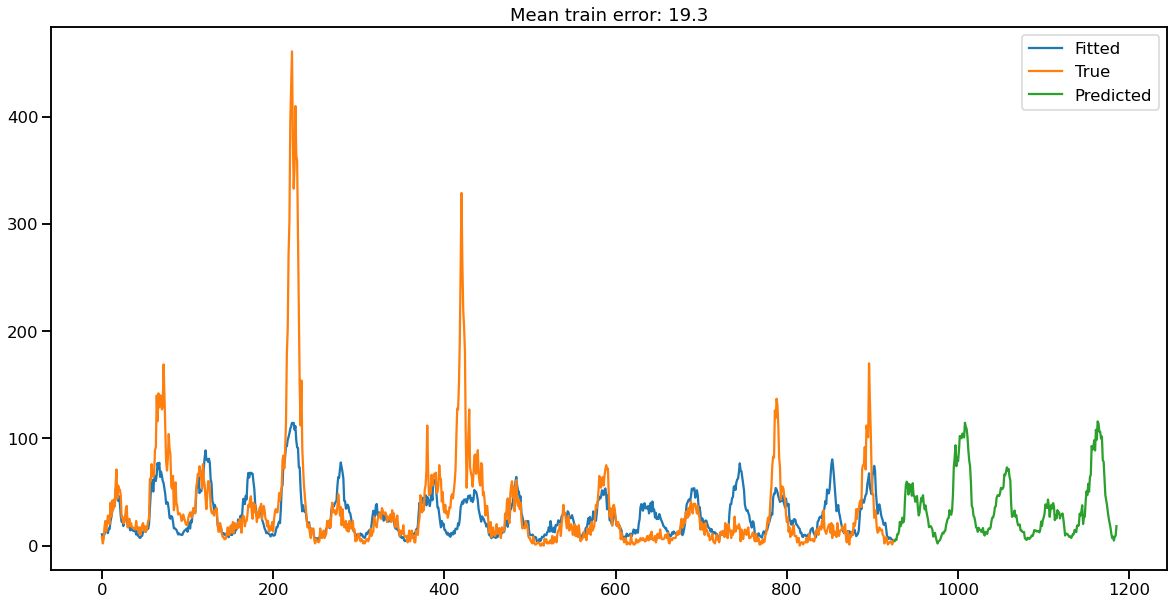

In [7]:
sj_model, sj_train_preds, sj_test_preds = fit_and_predict_LSTM(sj_feature_train, sj_feature_test, epochs = 400, n_hidden = 40, verbose = 2)

In [8]:
output_sj = pd.DataFrame(np.append(sj_train_preds, sj_test_preds))

Text(0, 0.5, 'total_cases')

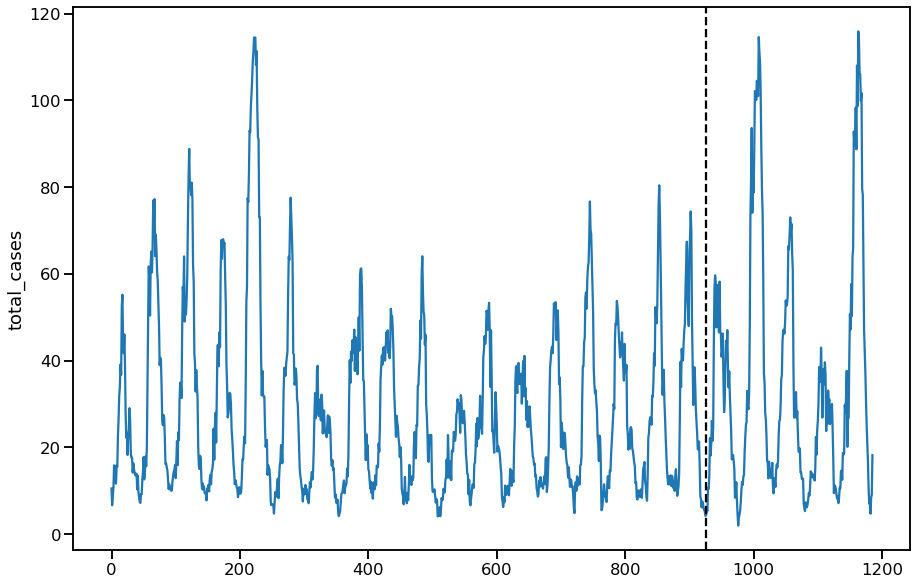

In [9]:
fig, ax = plt.subplots(figsize = (15,10))
output_sj[0].plot(ax = ax)
ax.axvline(len(sj_train_preds), linestyle = 'dashed', color = 'black')
ax.set_ylabel('total_cases')

In [10]:
iq_feature_train_log_cases = iq_feature_train.copy()
iq_feature_train_log_cases['total_cases'] = np.log(1 + iq_feature_train_log_cases['total_cases'])

Train on 240 samples, validate on 200 samples
Epoch 1/50
 - 1s - loss: 8.7526 - val_loss: 8.8502
Epoch 2/50
 - 0s - loss: 8.6515 - val_loss: 8.7786
Epoch 3/50
 - 0s - loss: 8.5855 - val_loss: 8.7014
Epoch 4/50
 - 0s - loss: 8.4753 - val_loss: 8.6147
Epoch 5/50
 - 0s - loss: 8.3650 - val_loss: 8.5157
Epoch 6/50
 - 0s - loss: 8.2213 - val_loss: 8.4055
Epoch 7/50
 - 0s - loss: 8.1231 - val_loss: 8.2860
Epoch 8/50
 - 0s - loss: 7.9691 - val_loss: 8.1505
Epoch 9/50
 - 0s - loss: 7.8039 - val_loss: 7.9968
Epoch 10/50
 - 0s - loss: 7.6859 - val_loss: 7.8291
Epoch 11/50
 - 0s - loss: 7.4847 - val_loss: 7.6504
Epoch 12/50
 - 0s - loss: 7.2980 - val_loss: 7.4545
Epoch 13/50
 - 0s - loss: 7.0673 - val_loss: 7.2448
Epoch 14/50
 - 0s - loss: 7.0051 - val_loss: 7.0435
Epoch 15/50
 - 0s - loss: 6.8842 - val_loss: 6.8648
Epoch 16/50
 - 0s - loss: 6.8053 - val_loss: 6.7097
Epoch 17/50
 - 0s - loss: 6.7960 - val_loss: 6.5816
Epoch 18/50
 - 0s - loss: 6.6282 - val_loss: 6.4714
Epoch 19/50
 - 0s - loss: 6

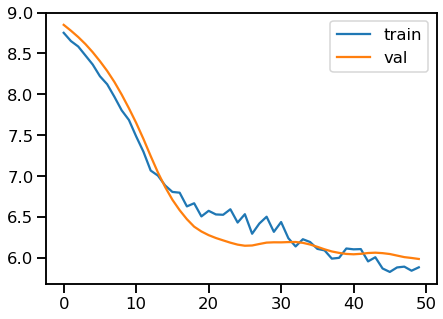

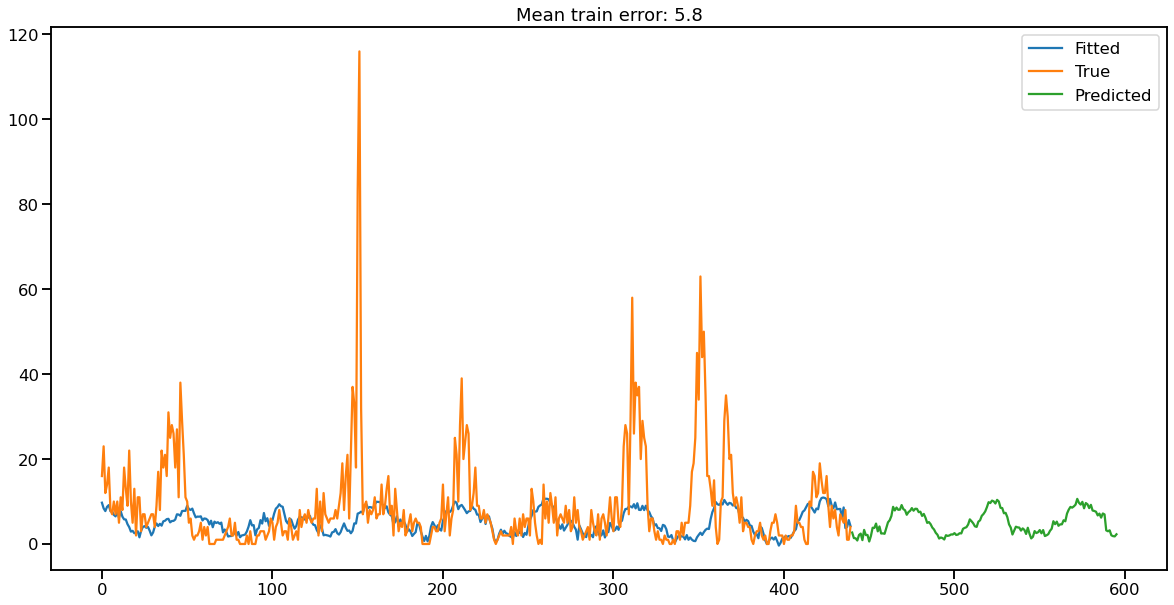

In [11]:
iq_model, iq_train_preds, iq_test_preds = fit_and_predict_LSTM(iq_feature_train.iloc[70:,:], iq_feature_test, epochs = 50, n_hidden = 40, verbose = 2)

In [12]:
output_iq = pd.DataFrame(np.append(iq_train_preds, iq_test_preds))
output_iq['total_cases'] = np.expm1(output_iq[0]).astype(int)

Text(0, 0.5, 'total_cases')

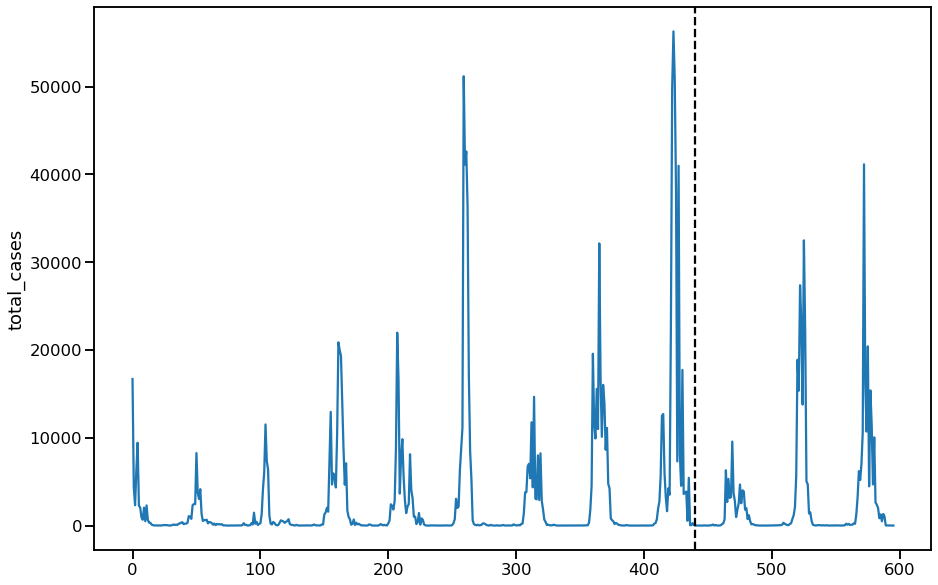

In [13]:
fig, ax = plt.subplots(figsize = (15,10))
output_iq['total_cases'].plot(ax = ax)
ax.axvline(len(iq_train_preds), linestyle = 'dashed', color = 'black')
ax.set_ylabel('total_cases')

In [14]:
# Finalize model
sj_model = pd.DataFrame(sj_test_preds.astype(int), columns = ['total_cases'])
sj_model['year'] = sj_feature_test['year']
sj_model['weekofyear'] = sj_feature_test['weekofyear']
sj_model['city'] = 'sj'

In [15]:
iq_model = pd.DataFrame(iq_test_preds.astype(int), columns = ['total_cases'])
iq_model['year'] = iq_feature_test['year']
iq_model['weekofyear'] = iq_feature_test['weekofyear']
iq_model['city'] = 'iq'

In [16]:
model = sj_model.append(iq_model)[['city', 'year', 'weekofyear', 'total_cases']]
model.loc[model['total_cases'] < 0, 'total_cases'] = 0

In [17]:
model

,city,year,weekofyear,total_cases
0,sj,2008,18,4
1,sj,2008,19,5
2,sj,2008,20,5
3,sj,2008,21,10
4,sj,2008,22,10
...,...,...,...,...
151,iq,2013,22,3
152,iq,2013,23,2
153,iq,2013,24,1
154,iq,2013,25,1


<AxesSubplot:>

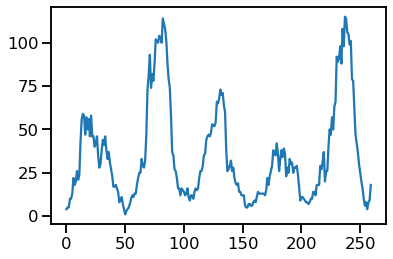

In [18]:
model[model['city'] == 'sj']['total_cases'].plot()

<AxesSubplot:>

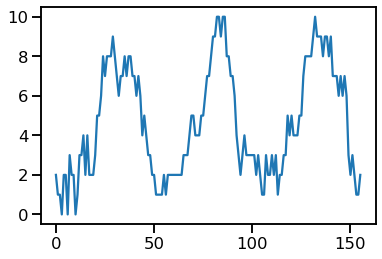

In [19]:
model[model['city'] == 'iq']['total_cases'].plot()

In [20]:
import time
today = time.strftime('%d-%m-%Y')
model.to_csv(model_path + '/Keras_LSTM_' + output_feature_fname + '_' + today + '.csv', index = False)